# Synthetic analysis

Based on the seqNMF paper (https://elifesciences.org/articles/38471.pdf), there are two regimes in which convolutional factorizations especially struggle:

    1. Temporal jitter -- the relative neural activations vary from instance to instance of the sequence
    2. Time warping -- some sequences are shorter or longer than others

In [4]:
using Revise
using Random
using Plots

using PointProcessSequences
using CMF

gr();  # set plotting backend

include("statistical_performance.jl")

eval (generic function with 3 methods)

### Simple example

Let's start by fitting a basic dataset.

("Background: ", sum(ids .== 1)) = ("Background: ", 36)
("Sequence: ", sum(ids .== 2)) = ("Sequence: ", 36)


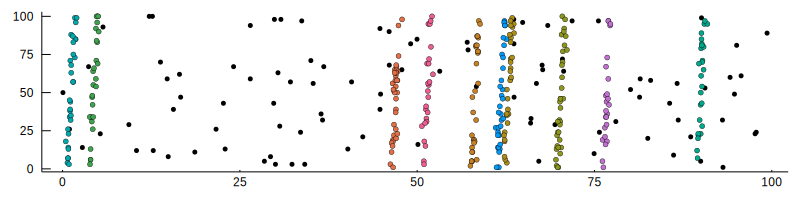

In [7]:
max_time = 100.0
events, spikes, ids = generate_data(
    seed=74,
    bkgd_rate=0.01,
    seq_event_rate=0.1,
    seq_amplitude_mean=30.0,
    max_time=max_time,
)
    
@show "Background: ", sum(ids .== 1)
@show "Sequence: ", sum(ids .== 2)

plot_raster(spikes, ids)

In [25]:
max_sequence_length = 10.0
bkgd_rate = 0.01
num_neurons = 100
amplitude_mean = 30.0
amplitude_var = 10.0^2
seq_width = 0.2

seq_event_rate = 0.1
seq_type_proportions = SymmetricDirichlet(1.0, 1)

bkgd_amplitude = specify_gamma(   
    bkgd_rate,     # mean of gamma; α / β
    bkgd_rate * 1e-5,     # variance of gamma; α / β²
)
bkgd_proportions = SymmetricDirichlet(1.0, num_neurons)

seq_event_amplitude = specify_gamma(amplitude_mean, amplitude_var)
neuron_response_proportions = SymmetricDirichlet(0.1, num_neurons)
neuron_response_profile = NormalInvChisq(
    1.0,   # κ, pseudo-observations of prior mean
    0.0,   # m, prior mean for offset parameter
    2.0,   # ν, pseudo-observations of prior variance
    seq_width    # s2, prior variance
)

model = PPSeq(
    max_time,
    max_sequence_length,

    # priors
    seq_event_rate,
    seq_type_proportions,
    seq_event_amplitude,
    neuron_response_proportions,
    neuron_response_profile,
    bkgd_amplitude,
    bkgd_proportions
)
println("Model initialized.")

Model initialized.


In [26]:
num_anneals, max_temp = 10, 75.0
samples_per_anneal, save_every = 1000, 10


@time assignment_hist, logp_hist = annealed_gibbs!(
    model, spikes, num_anneals, 
    samples_per_anneal, max_temp, 0, 0.0, save_every
);

TEMP:  75.00000000000001
10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-520-530-540-550-560-570-580-590-600-610-620-630-640-650-660-670-680-690-700-710-720-730-740-750-760-770-780-790-800-810-820-830-840-850-860-870-880-890-900-910-920-930-940-950-960-970-980-990-1000-Done
TEMP:  46.42170880670483
10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-520-530-540-550-560-570-580-590-600-610-620-630-640-650-660-670-680-690-700-710-720-730-740-750-760-770-780-790-800-810-820-830-840-850-860-870-880-890-900-910-920-930-940-950-960-970-980-990-1000-Done
TEMP:  28.733000647126627
10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350

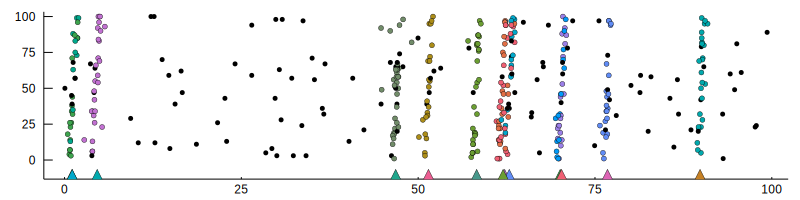

In [27]:
est_ids = assignment_hist[:, end]
events = [
    (ind+2, model.sequence_events[ind].sampled_timestamp) 
    for ind in model.sequence_events.indices
]

plot_raster(spikes, est_ids, events=events)

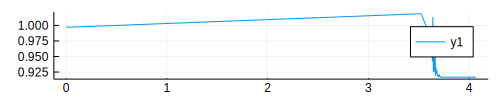

fit


In [28]:
# Bin the data
binsize = 0.2
N, T = num_neurons, floor(Int, max_time / binsize)
datamat = zeros(N, T)

for spk in spikes
    datamat[spk.neuron, ceil(Int, spk.timestamp/binsize + eps())] += 1
end

# Fit with CMF
K, L = 1, floor(Int, 2/binsize)
r = fit_cnmf(
    datamat,
    L=L, K=K, alg=PGDUpdate,
    max_itr=100, max_time=30,
    constrW=CMF.NonnegConstraint(),
    penaltiesW=[CMF.SquarePenalty(1)],
    penaltiesH=[CMF.AbsolutePenalty(0.1)],
    check_convergence=false,
    seed=7
)
xhat = CMF.tensor_conv(r.W, r.H);

p = plot(r.time_hist, r.loss_hist, size=(500, 100))
display(p)

println("fit")

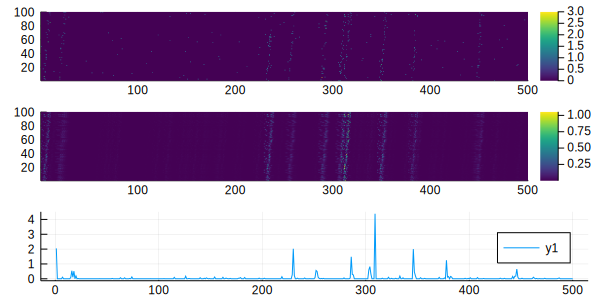

In [29]:
p1 = heatmap(datamat, size=(600, 300), c=:viridis)
p2 = heatmap(xhat, size=(600, 300), c=:viridis)
p3 = plot(r.H[1, :], size=(600, 300))
plot(p1, p2, p3, layout=(3, 1))

### Lots of temporal jitter

Now let's amp up the sequence width.

In [ ]:
max_time = 100.0
bkgd_rate = 0.01
seq_event_rate = 0.1
amplitude_mean = 30.0

events, spikes, ids = generate_data(
    seed=74,
    bkgd_rate=bkgd_rate,
    event_rate=seq_event_rate,
    seq_amplitude_mean=amplitude_mean,
    max_time=max_time,
    seq_width=0.8
)

plot_raster(spikes, ids)

In [ ]:
max_sequence_length = 10.0
num_neurons = 100
amplitude_var = 10.0^2

seq_type_proportions = SymmetricDirichlet(1.0, 1)

bkgd_amplitude = specify_gamma(   
    bkgd_rate * max_time,     # mean of gamma; α / β
    bkgd_rate * max_time,     # variance of gamma; α / β²
)
bkgd_proportions = SymmetricDirichlet(1.0, num_neurons)

seq_event_amplitude = specify_gamma(amplitude_mean, amplitude_var)
neuron_response_proportions = SymmetricDirichlet(0.1, num_neurons)
neuron_response_profile = NormalInvChisq(
    1.0,   # κ, pseudo-observations of prior mean
    0.0,   # m, prior mean for offset parameter
    2.0,   # ν, pseudo-observations of prior variance
    seq_width    # s2, prior variance
)

model = PPSeq(
    max_time,
    max_sequence_length,

    # priors
    seq_event_rate,
    seq_type_proportions,
    seq_event_amplitude,
    neuron_response_proportions,
    neuron_response_profile,
    bkgd_amplitude,
    bkgd_proportions
)
println("Model initialized.")

In [ ]:
num_anneals, max_temp = 5, 10.0
samples_per_anneal, save_every = 1000, 50

@time assignment_hist, logp_hist = annealed_gibbs!(
    model, spikes, num_anneals, 
    samples_per_anneal, max_temp, save_every
);

plot(logp_hist, size=(500, 200))

In [ ]:
est_ids = assignment_hist[:, end]
events = [
    (ind+2, model.sequence_events[ind].sampled_timestamp) 
    for ind in model.sequence_events.indices
]

plot_raster(spikes, est_ids .+ 2, events=events)

In [ ]:
# Bin the data
binsize = 0.2
N, T = num_neurons, floor(Int, max_time / binsize)
datamat = zeros(N, T)

for spk in spikes
    datamat[spk.neuron, ceil(Int, spk.timestamp/binsize + eps())] += 1
end

# Fit with CMF
K, L = 1, floor(Int, 3/binsize)
r = fit_cnmf(
    datamat,
    L=L, K=K, alg=PGDUpdate,
    max_itr=200, max_time=3,
    constrW=CMF.UnitNormConstraint(),  #CMF.NonnegConstraint(),
    penaltiesW=[],  #[CMF.SquarePenalty(1)],
    penaltiesH=[CMF.AbsolutePenalty(0.1)],
    check_convergence=false,
    seed=7
)
xhat = max.(0, CMF.tensor_conv(r.W, r.H));

p = plot(r.time_hist, r.loss_hist, size=(500, 100))
display(p)

println("fit")

p1 = heatmap(datamat, size=(600, 300), c=:viridis)
p2 = heatmap(xhat, size=(600, 300), c=:viridis)
p3 = plot(r.H[1, :], size=(600, 300))
plot(p1, p2, p3, layout=(3, 1))

### Takeaways

- Without much temporal jitter, both PP-Seq and convolutional factorizations perform well.
- When the temporal jitter increases, convolutional factorizations **FAIL** (*for now*). However, explicitly modeling the variance of the neural response profile let's pp-SEQ capture this behavior.


**Up next** a plot to quantify this :)